In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [10]:
def generate_gaussian_steps(num_steps):
    """Generate X_1 to X_n that are iid gaussian """
    X = np.random.normal(size=num_steps)
    return X

def generate_gaussian_steps_dt(num_steps, dt):
    """Generate X_1 to X_n that are iid gaussian """
    X = np.random.normal(size=num_steps)
    return X*np.sqrt(dt)

def generate_random_walk_path(steps, n):
    """Generate a random walk that is shrunk in space and sped up in time from a sequence of steps
        steps size: n*t
        return size: t
    """
    Y = np.array([0])
    for k in range(n):
        Y = np.concatenate( (Y, np.cumsum(steps[0:k+1])/np.sqrt(n) ) )
    return Y



### Question 1

\begin{eqnarray}
    \Delta W_n = W(t_{n+1}) - W(t_n) \\
            Y_t = Y_0 \exp{ (\mu-\sigma^2/2)t + \sigma W_t }
\end{eqnarray}

## MLMC Questions

### 1. Simulate Geometric Brownian Motion

In [14]:
def generate_geometric_brownian_motion(dW, N):
    '''
    Euler Maruyama Inetgration
    '''
    Y = [1.0]
    mu = 0.05
    sigma = 0.2
    for n in range(N):
        Y_n = Y[-1]
        bt = mu*Y_n
        ht = sigma*Y_n
        delta_W = dW[n]
        Y_next = Y_n + bt*dt + ht*delta_W
        Y.append(Y_next)
    return np.asarray(Y)

### 4.1 (1)

In [15]:
TF = 1
N_DIVISIONS = 100
dt = TF/N_DIVISIONS
num_trials = 1000
num_samples = int(np.ceil(TF/dt))
estimator_vals = np.zeros((num_trials, num_samples+1))
for trial in range(num_trials):
    delta_W = generate_gaussian_steps_dt(num_samples,dt)  # Use these as Delta W_n
    estimator_vals[trial, :] = generate_geometric_brownian_motion(delta_W, num_samples)

shape (1000, 101)


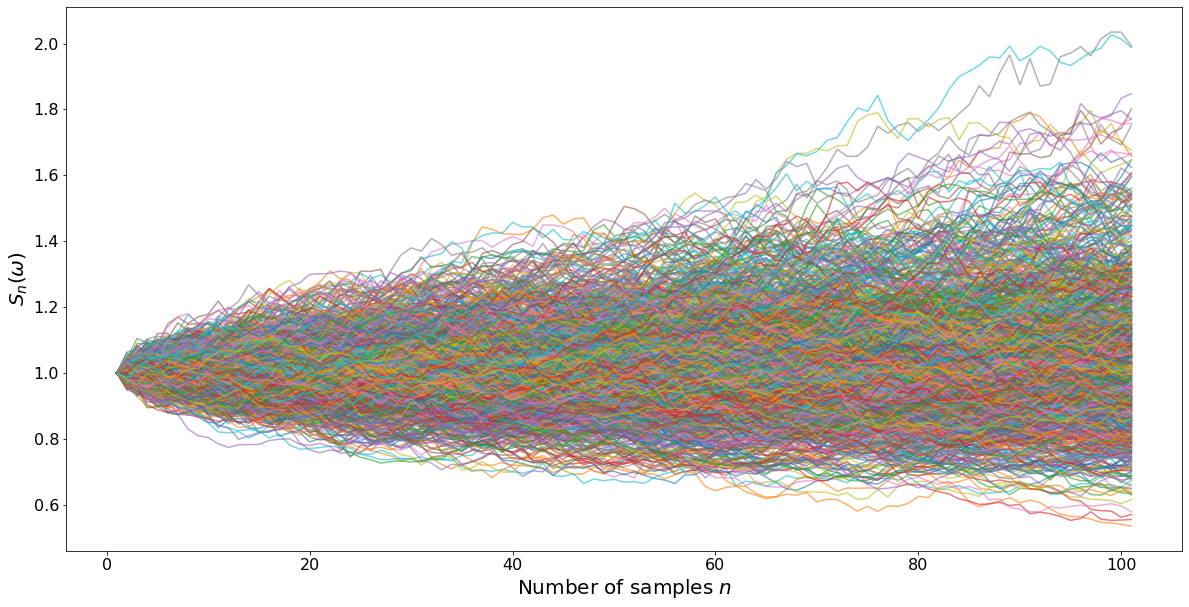

In [16]:
print("shape",np.shape(estimator_vals))
plt.figure(figsize=(20,10))
plt.plot(np.arange(1, num_samples+2), estimator_vals.T, alpha=0.6)
plt.ylabel(r'$S_n(\omega)$', fontsize=20)
plt.xlabel(r'Number of samples $n$', fontsize=20)
plt.xticks(fontsize=16)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
plt.yticks(fontsize=16)
plt.show()

In [19]:
index_1 = int(1.0/dt)
print("Mean at 1 = ", np.mean(estimator_vals[:,index_1]))
print("Variance at 1 = ", np.var(estimator_vals[:,index_1]))

Mean at 1 =  1.0585602872201847
Variance at 1 =  0.04614579414638381


#### Analytic Mean of Y(1)

\begin{eqnarray}
            Y_t = Y_0 e^{ (\mu-\sigma^2/2)t + \sigma W_t } \\
            E[Y_t] = Y_0 e^{\mu-\sigma^2/2}E[e^{\sigma W_t}]
\end{eqnarray}

### 4.1 (2)

In [20]:
def brownian_fine_to_coarse(T, dt, brownian_fine, M):
    num_samples =  int(np.ceil(T/dt)) + 1
    num_paths = brownian_fine.shape[0]
    brownian_coarse = np.zeros((num_paths, num_samples))
    brownian_coarse[0,:] = brownian_[0,:]
    for ii in range(1, num_samples):
        delta = brownian_fine[:, ii * M] - brownian_fine[:, (ii-1)*M]
        brownian_coarse[:, ii] = brownian_coarse[:, ii] + delta
    return brownian_coarse
    